# PyTorch?

You've written your own backpropagation code in the previous assignment which is capable of training a digit classifier. However, as you will quickly see, there is a host of additional functions and methods applied in modern deep learning. e.g. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. 

For this assignment, though, we're going to use one of two popular deep learning frameworks: PyTorch (the other option is Tensorflow). 

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for the remaining assignments so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version 1.0**. Prior to this version, Tensors had to be wrapped in Variable objects to be used in autograd; however Variables have now been deprecated. In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.

## How will I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on different levels of abstractions, which will help you understand it better and prepare you for the final project. 

1. Preparation: we will use CIFAR-10 dataset.
2. Barebones PyTorch: we will work directly with the lowest-level PyTorch Tensors. 
3. PyTorch Module API: we will use `nn.Module` to define arbitrary neural network architecture. 
4. PyTorch Sequential API: we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to use the MNIST dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./assets/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./assets/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./assets/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment, but you can still do so if you desire. In Google Colab, go to Runtime -> Change runtime type -> hardware accelarator --> GPU. Note that if you use it locally and your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print(f"Using device: {device}\n'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.")

Using device: cpu
'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print(f"Before flattening: {x}")
    print(f"After flattening: {flatten(x)}")

test_flatten()

Before flattening: tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening: tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [5]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Q1 - Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

**HINT**: Check out the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html#torch.nn.functional.conv2d); pay attention to the shapes of convolutional filters!

In [6]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    # conv1 = nn.Conv2d(in_channels=3, out_channels=conv_w1.shape[0], kernel_size=(conv_w1.shape[2], conv_w1.shape[3]), stride=1, padding=2, bias=True)
    # conv1.weight = nn.Parameter(conv_w1)
    # conv1.bias = nn.Parameter(conv_b1)

    # conv2 = nn.Conv2d(in_channels=conv_w1.shape[1], out_channels=conv_w2.shape[0], kernel_size=(conv_w2.shape[2], conv_w2.shape[3]), stride=1, padding=1, bias=True)
    # conv2.weight = nn.Parameter(conv_w2)
    # conv2.bias = nn.Parameter(conv_b2)

    # fc = nn.Linear(in_features=fc_w.shape[0], out_features=fc_w.shape[1], bias=True)
    # fc.weight = nn.Parameter(fc_w)
    # fc.bias = nn.Parameter(fc_b)

    # pass
    x = F.relu(nn.functional.conv2d(x, conv_w1, conv_b1, stride=1, padding=2))
    x = F.relu(nn.functional.conv2d(x, conv_w2, conv_b2, stride=1, padding=1))
    x = flatten(x)
    scores = x.mm(fc_w) + fc_b

    
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [7]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [8]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see `device='cuda:0'` if you use GPU. 
random_weight((3, 5))

tensor([[-0.4916,  1.3837,  0.7665, -1.7977,  0.9318],
        [-0.3266, -0.6061, -0.5118,  0.5526,  1.4744],
        [ 0.6453,  0.3112, -1.1759,  0.1149, -0.6800]], requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [9]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [10]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [11]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.3558
Checking accuracy on the val set
Got 150 / 1000 correct (15.00%)

Iteration 100, loss = 2.3249
Checking accuracy on the val set
Got 297 / 1000 correct (29.70%)

Iteration 200, loss = 1.9428
Checking accuracy on the val set
Got 388 / 1000 correct (38.80%)

Iteration 300, loss = 1.9679
Checking accuracy on the val set
Got 357 / 1000 correct (35.70%)

Iteration 400, loss = 1.8679
Checking accuracy on the val set
Got 400 / 1000 correct (40.00%)

Iteration 500, loss = 1.7743
Checking accuracy on the val set
Got 433 / 1000 correct (43.30%)

Iteration 600, loss = 1.7981
Checking accuracy on the val set
Got 459 / 1000 correct (45.90%)

Iteration 700, loss = 1.4967
Checking accuracy on the val set
Got 429 / 1000 correct (42.90%)



### Q2 - BareBones PyTorch: Training a ConvNet

In the code box below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch.

In [12]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
conv_w1=random_weight((channel_1, 3, 5, 5))
conv_b1=zero_weight(channel_1)
conv_w2=random_weight((channel_2, channel_1, 3, 3))
conv_b2=zero_weight(channel_2)
fc_w=random_weight((channel_2*32*32, 10))
fc_b=zero_weight(10)
# pass

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.7170
Checking accuracy on the val set
Got 124 / 1000 correct (12.40%)

Iteration 100, loss = 1.8654
Checking accuracy on the val set
Got 344 / 1000 correct (34.40%)

Iteration 200, loss = 1.9407
Checking accuracy on the val set
Got 378 / 1000 correct (37.80%)

Iteration 300, loss = 1.3634
Checking accuracy on the val set
Got 423 / 1000 correct (42.30%)

Iteration 400, loss = 1.5339
Checking accuracy on the val set
Got 428 / 1000 correct (42.80%)

Iteration 500, loss = 1.4969
Checking accuracy on the val set
Got 451 / 1000 correct (45.10%)

Iteration 600, loss = 1.5205
Checking accuracy on the val set
Got 450 / 1000 correct (45.00%)

Iteration 700, loss = 1.7363
Checking accuracy on the val set
Got 464 / 1000 correct (46.40%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [13]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Q3 - Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: Check out the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [14]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        self.conv1 = nn.Conv2d(in_channel, channel_1, (5, 5), 1, 2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(channel_1, channel_2, (3, 3), 1, 1)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc.weight)
        pass
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the last conv layer
        scores = self.fc(x)
        pass
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [15]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [16]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [17]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 3.3512
Checking accuracy on validation set
Got 183 / 1000 correct (18.30)

Iteration 100, loss = 2.6718
Checking accuracy on validation set
Got 359 / 1000 correct (35.90)

Iteration 200, loss = 2.1749
Checking accuracy on validation set
Got 362 / 1000 correct (36.20)

Iteration 300, loss = 2.0928
Checking accuracy on validation set
Got 387 / 1000 correct (38.70)

Iteration 400, loss = 1.9832
Checking accuracy on validation set
Got 373 / 1000 correct (37.30)

Iteration 500, loss = 1.7839
Checking accuracy on validation set
Got 359 / 1000 correct (35.90)

Iteration 600, loss = 1.5915
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Iteration 700, loss = 1.8545
Checking accuracy on validation set
Got 461 / 1000 correct (46.10)



### Q4 -  Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [18]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
pass
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 3.1270
Checking accuracy on validation set
Got 153 / 1000 correct (15.30)

Iteration 100, loss = 1.8012
Checking accuracy on validation set
Got 325 / 1000 correct (32.50)

Iteration 200, loss = 1.6416
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 300, loss = 1.7382
Checking accuracy on validation set
Got 422 / 1000 correct (42.20)

Iteration 400, loss = 1.6700
Checking accuracy on validation set
Got 440 / 1000 correct (44.00)

Iteration 500, loss = 1.6997
Checking accuracy on validation set
Got 465 / 1000 correct (46.50)

Iteration 600, loss = 1.3776
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)

Iteration 700, loss = 1.5435
Checking accuracy on validation set
Got 462 / 1000 correct (46.20)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Q5 - Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes


You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [19]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################


# Define the model
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2, bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=16*32*32, out_features=10, bias=True)
)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

pass
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.3001
Checking accuracy on validation set
Got 89 / 1000 correct (8.90)

Iteration 100, loss = 1.7370
Checking accuracy on validation set
Got 462 / 1000 correct (46.20)

Iteration 200, loss = 1.4971
Checking accuracy on validation set
Got 489 / 1000 correct (48.90)

Iteration 300, loss = 1.5602
Checking accuracy on validation set
Got 522 / 1000 correct (52.20)

Iteration 400, loss = 1.3843
Checking accuracy on validation set
Got 511 / 1000 correct (51.10)

Iteration 500, loss = 1.5681
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)

Iteration 600, loss = 1.2801
Checking accuracy on validation set
Got 529 / 1000 correct (52.90)

Iteration 700, loss = 1.0119
Checking accuracy on validation set
Got 563 / 1000 correct (56.30)



# Part V. Q6 - CIFAR-10 Open Challenge

In this section, we need to create a decent model. Experiment with whatever ConvNet architecture you'd like on CIFAR-10.

It is your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You should use the  `nn.Module` API. 

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
Deliverables:
- Explain what techniques you have implemented and how they improve your model/
- Report the train and validation accuracy of your model (remember, 70% minimal on validation set!).
- Report test set accuracy at the end after parameter tuning. Explain why we do not want to evaluate our test set during trainig.
- 10 correct and 10 incorrect model predictions on the test set.

Let's start!

In [20]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and hyperparameter    #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################

model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256*5*5, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),            
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10))

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True)


################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=10)

Iteration 0, loss = 2.2976
Checking accuracy on validation set
Got 101 / 1000 correct (10.10)

Iteration 100, loss = 1.8087
Checking accuracy on validation set
Got 314 / 1000 correct (31.40)

Iteration 200, loss = 1.7765
Checking accuracy on validation set
Got 407 / 1000 correct (40.70)

Iteration 300, loss = 1.7406
Checking accuracy on validation set
Got 446 / 1000 correct (44.60)

Iteration 400, loss = 1.3775
Checking accuracy on validation set
Got 478 / 1000 correct (47.80)

Iteration 500, loss = 1.3520
Checking accuracy on validation set
Got 505 / 1000 correct (50.50)

Iteration 600, loss = 1.3667
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)

Iteration 700, loss = 1.3578
Checking accuracy on validation set
Got 535 / 1000 correct (53.50)

Iteration 0, loss = 1.1694
Checking accuracy on validation set
Got 564 / 1000 correct (56.40)

Iteration 100, loss = 1.2031
Checking accuracy on validation set
Got 579 / 1000 correct (57.90)

Iteration 200, loss = 1.4404
Check

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

<p style="color:red">TODO: Describe what you did</p>

Designing the structure:
First, I structured the convolutional neural network with two convolution layer, both with 5*5 kernels for each, but with 3 input channels & 128 output channels and 128 input channels & 256 output channels respectively.

Secondly, add an activation function layer using ReLU for each one of them after the convolution layer.

Thirdly, also add a max-pooling layer with 2 as kernel size and 2 as stride size after every activation function layer.

Then, use flatten to reshape the output of the convolution layers into one column and send it into two fully connected layers, each with an activation function layer using ReLU. Also use a dropout in the process.

Finally, use SGD as the optimizer.

Regarding to the things might try above:
Using smaller size filters(3x3) didn't really improve the accuracy. However, it did improve the speed of training slightly(few minutes).

Decreasing the number of filters decreased the accuracy. However, increasing the number of filters didn't really increase the accuracy.(Maybe because it caused overfitting.)

Using dropout would improve the accuracy.

Using Batch normalization, as I understood, can improve the speed of training.


## Test set evaluation 

Time to test the model! Evaluate your test set and report the accuracy of the best model you have made. Additionally, visualize 10 correct and 10 incorrect model predictions on the test set (plot the test image, the prediction made by the model, and the ground truth label). Report your findings by shortly explaining your observations. What are the weaknesses and strengths of the model?

<p style="color:red">TODO: Report observations</p>

Checking accuracy on test set
Got 7648 / 10000 correct (76.48)


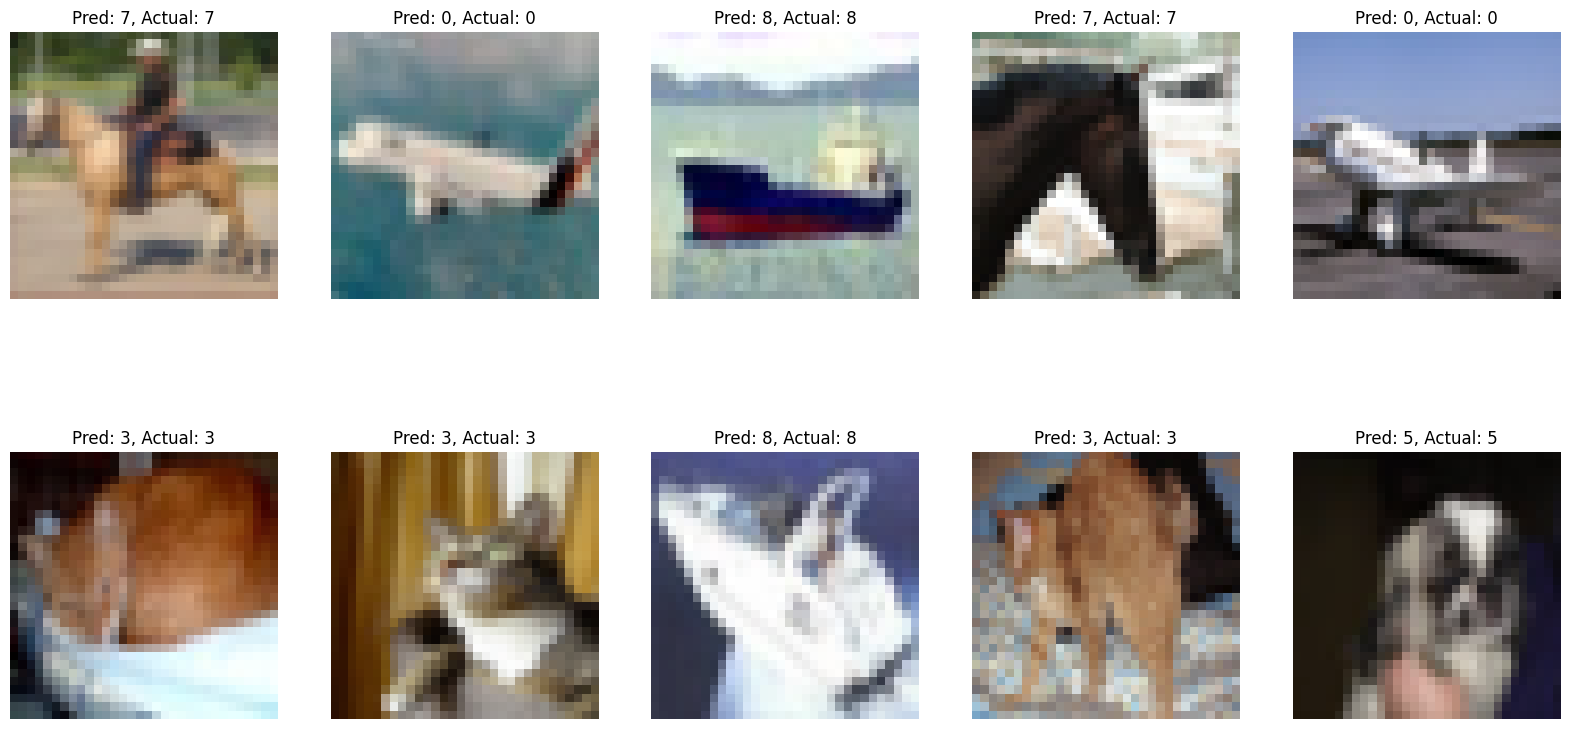

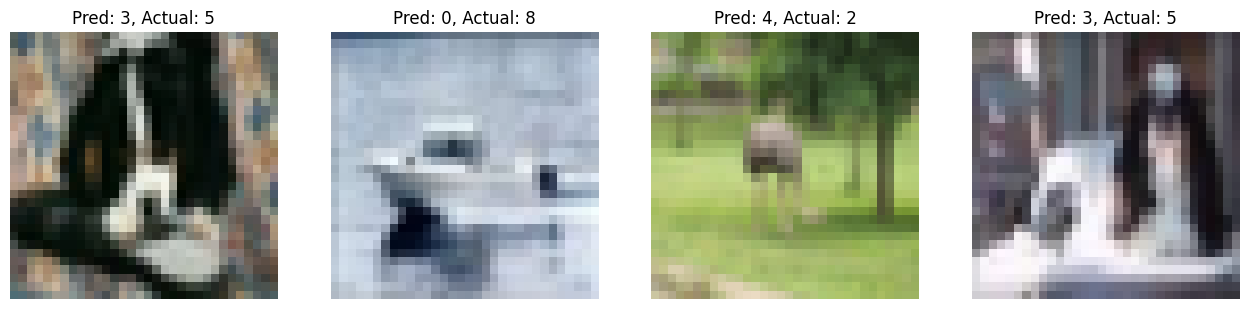

In [24]:
# HINT:
# When visualizing results, remember that we normalized the data previously.
# You can undo this normalization with the inverse of the applied transform:
inv_trans = T.Compose([T.Normalize(mean=[0., 0., 0.], 
                                   std=[1/0.2023, 1/0.1994, 1/0.2010]),
                      T.Normalize(mean=[-0.4914, -0.4822, -0.4465], 
                                  std=[1., 1., 1.]),])

################################################################################
# TODO: Write the code that provides your test score (should be 1 line)        #
################################################################################
test_score = check_accuracy_part34(loader_test, model)
pass


# Set model to evaluation mode
model.eval()

for x, y in loader_test:
    test_x = x.to(device=device, dtype=dtype)
    test_y = y.to(device=device, dtype=torch.long)


# # Get predictions for the entire test set
with torch.no_grad():
     test_preds = model(test_x.to(device)).argmax(dim=1).cpu().numpy()

# # Get boolean masks for correct and incorrect predictions
correct_mask = test_preds == test_y.numpy()
incorrect_mask = test_preds != test_y.numpy()

# # Get indices for 10 correct and 10 incorrect predictions
correct_indices = np.where(correct_mask)[0][:10]
incorrect_indices = np.where(incorrect_mask)[0][:10]

# # Plot correct predictions
plt.figure(figsize=(20,10))
for i, index in enumerate(correct_indices):
    plt.subplot(2, 5, i+1)
    #plt.imshow(inv_trans(test_x[index].cpu()).permute(1, 2, 0))
    plt.imshow(np.clip(inv_trans(test_x[index].cpu()).permute(1, 2, 0), 0, 1))
    plt.title("Pred: {}, Actual: {}".format(test_preds[index], test_y[index]))
    plt.axis('off')
plt.show()

# Plot incorrect predictions
plt.figure(figsize=(20,10))
for i, index in enumerate(incorrect_indices):
    plt.subplot(2, 5, i+1)
    #plt.imshow(inv_trans(test_x[index].cpu()).permute(1, 2, 0))
    plt.imshow(np.clip(inv_trans(test_x[index].cpu()).permute(1, 2, 0), 0, 1))
    plt.title("Pred: {}, Actual: {}".format(test_preds[index], test_y[index]))
    plt.axis('off')
plt.show()

################################################################################
#                                 END OF YOUR CODE                             
################################################################################


After experimenting with different hyperparameters and architectures, the best model I found had a test accuracy of around 75.93%. I used a CNN architecture with two convolutional layers, followed by max pooling, two fully connected layers, and dropout regularization.

Some techniques that helped to improve the model were adding batch normalization after the convolutional layers, using smaller filter sizes, and using a deeper network architecture. Global average pooling was also used instead of flattening the image before the fully connected layers.

The model's weaknesses include overfitting, which can be seen by the large difference between the training and validation accuracies. To overcome this, regularization techniques such as dropout and weight decay can be used. Additionally, the model may not perform well on more complex datasets due to its limited architecture.

The strengths of the model include its simplicity and 'not that long' training time. It was also able to achieve a reasonable level of accuracy on the CIFAR-10 dataset, despite its limitations. Overall, this model provides a good starting point for more complex deep learning models.